In [2]:
from matplotlib.image import imread
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import Counter

In [3]:
#resize board image to (640, 640)
def resize_board_image(img_path):
    img = Image.open(img_path)
    img = img.resize((640, 640))
    img.save(img_path)
    return img_path

In [4]:
def grayscale(board):
    #grayscale value
    #RGB Value to grayscale formula (NTSC):
    #0.299 ∙ Red + 0.587 ∙ Green + 0.114 ∙ Blue
    board_gray = []
    for i in range(board.shape[0]):
        board_gray_row = []
        for j in range (board.shape[1]):
            r = board[i,j,0]
            g = board[i,j,1]
            b = board[i,j,2]
            board_gray_row.append(0.299*r + 0.587*g + 0.114*b)
        board_gray.append(board_gray_row)
    return np.array(board_gray)

In [5]:
#crop out border
def crop(source, value):
    square = []
    for i in range(int(source.shape[0]*value), int(source.shape[0]*(1-value))):
        square_row = []
        for j in range (int(source.shape[0]*value), int(source.shape[0]*(1-value))):
            square_row.append(source[i][j])
        square.append(square_row)
    return np.array(square)

In [6]:
def get_squares(board):
    squares = []
    square_width = int(board.shape[0]/8)
    square_height = int(board.shape[1]/8)
    for i in range(8):
        squares_row = []
        for j in range (8):
            square = board[(square_height*i):(square_height*(i+1)), (square_width*j):(square_width*(j+1))]
            squares_row.append(crop(square, 0.125))
        squares.append(squares_row)
    return np.array(squares)

In [7]:
def prewitt(square):
    square_height, square_width = square.shape
    #prewitt kernel
    h_filter = np.array([[-1, 0, 1], 
                        [-1, 0, 1], 
                        [-1, 0, 1]])
    v_filter = np.array([[-1, -1, -1], 
                        [ 0,  0,  0], 
                        [ 1,  1,  1]])

    #initialize gradient image
    gradient_image = np.zeros((square_height, square_width))

    for i in range(1, square_height - 1):
        for j in range(1, square_width - 1):
            h_value = (h_filter[0, 0] * square[i - 1, j - 1]) + \
                      (h_filter[0, 1] * square[i - 1, j]) + \
                      (h_filter[0, 2] * square[i - 1, j + 1]) + \
                      (h_filter[1, 0] * square[i, j - 1]) + \
                      (h_filter[1, 1] * square[i, j]) + \
                      (h_filter[1, 2] * square[i, j + 1]) + \
                      (h_filter[2, 0] * square[i + 1, j - 1]) + \
                      (h_filter[2, 1] * square[i + 1, j]) + \
                      (h_filter[2, 2] * square[i + 1, j + 1])

            v_value = (v_filter[0, 0] * square[i - 1, j - 1]) + \
                      (v_filter[0, 1] * square[i - 1, j]) + \
                      (v_filter[0, 2] * square[i - 1, j + 1]) + \
                      (v_filter[1, 0] * square[i, j - 1]) + \
                      (v_filter[1, 1] * square[i, j]) + \
                      (v_filter[1, 2] * square[i, j + 1]) + \
                      (v_filter[2, 0] * square[i + 1, j - 1]) + \
                      (v_filter[2, 1] * square[i + 1, j]) + \
                      (v_filter[2, 2] * square[i + 1, j + 1])
            #value per pixel in gradient image
            magnitude = np.sqrt(pow(h_value, 2) + pow(v_value, 2))
            gradient_image[i - 1, j - 1] = magnitude
    return gradient_image

In [8]:
#check square occupancy
def is_occupied(square):
    square = square + 0.1e-16 #to avoid dividing by zero
    
    #horizontal pass
    filled_h = 0
    for i in range(square.shape[0]):
        target = 0
        ratio = 0
        for j in range(square.shape[1]/2):
            ratio = square[i, j+1] / square[i, j] #right:left pixel
            if ratio > 9: #prewitt creates high contrast between pixels on an edge
                target += 1
                break
        ratio = 0
        for j in range(square.shape[1]/2):
            ratio = square[i, square.shape[1]-j-2] / square[i, square.shape[1]-j-1] #left:right pixel
            if ratio > 9:
                target += 1
                break
        if target >= 2:
            filled_h += 1
        else:
            pass
    
    #vertical pass
    filled_v = 0
    for i in range(square.shape[1]):
        target = 0
        ratio = 0
        for j in range(square.shape[0]/2):
            ratio = square[j+1, i] / square[j, i] #bottom:top pixel
            if ratio > 9: 
                target += 1
                break
        ratio = 0
        for j in range(square.shape[0]/2):
            ratio = square[square.shape[1]-j-2, i] / square[square.shape[1]-j-1, i] #top:bottom pixel
            if ratio > 9:
                target += 1
                break
        if target >= 2:
            filled_v += 1
        else:
            pass
        
    return filled_h/square.shape[0] > 0.6 and filled_v/square.shape[1] > 0.3

In [9]:
#flag occupied squares
def flag_squares(squares): #prewitt input
    flags = []
    for s_row in squares:
        f_row = []
        for square in s_row:
            if is_occupied(square):
                f_row.append(1)
            else:
                f_row.append(0)
        flags.append(f_row)
    return np.array(flags)

In [10]:
#get feature vector
def feature_vector(array): #ndarray input
    return np.reshape(array, array.size)

In [11]:
#"distance" from avg_img
def euclidean_distance(v1, v2): #ndarray inputs
    if(v1.size != v2.size):
        print(f"Error: {v1.size} -> {v2.size}")
    squared_differences = 0
    for i in range(v1.size):
        squared_differences += pow((v1[i] - v2[i]), 2)
    return np.sqrt(squared_differences)

In [46]:
#binary classifier for piece color
class SVM:

    def __init__(self, weights, bias, learning_rate=0.001, reg=0.01):
        self.weights = weights
        self.bias = bias
        self.learning_rate = learning_rate
        self.reg = reg

    def predict(self, X):
        approx = np.dot(X, self.weights) - self.bias
        return np.sign(approx)

In [56]:
print(d_svm.weights, d_svm.bias, d_svm.learning_rate, d_svm.reg)

[0.24794673302037784, -0.30112104895118563] -2.087999999999881 0.001 0.01


In [48]:
#multi-class classifier for piece type
class KNN:
    def __init__(self, k):
        self.k=k
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return predictions
        
    def _predict(self, x):
        #get distances
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        
        #get closest k neighbors
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        #majority vote
        return Counter(k_nearest_labels).most_common()[0][0]

In [49]:
#import SVM

#dark squares SVM
d_svm_attributes = np.loadtxt("ndarray_txt/d_svm.txt")
d_weights = [d_svm_attributes[0], d_svm_attributes[1]]
d_bias = d_svm_attributes[2]
d_learning_rate = d_svm_attributes[3]
d_reg = d_svm_attributes[4]
d_svm = SVM(d_weights, d_bias, d_learning_rate, d_reg)

#light squares SVM
l_svm_attributes = np.loadtxt("ndarray_txt/d_svm.txt")
l_weights = [l_svm_attributes[0], l_svm_attributes[1]]
l_bias = l_svm_attributes[2]
l_learning_rate = l_svm_attributes[3]
l_reg = l_svm_attributes[4]
l_svm = SVM(l_weights, l_bias, l_learning_rate, l_reg)

In [50]:
#import avg_imgs
avg_img_db = np.loadtxt("ndarray_txt/avg_img_db.txt")
avg_img_dw = np.loadtxt("ndarray_txt/avg_img_dw.txt")
avg_img_lb = np.loadtxt("ndarray_txt/avg_img_lb.txt")
avg_img_lw = np.loadtxt("ndarray_txt/avg_img_lw.txt")

In [58]:
#import KNN
x_knn = np.loadtxt("ndarray_txt/x_knn.txt")
y_knn = np.loadtxt("ndarray_txt/y_knn.txt")
knn = KNN(3)
knn.fit(x_knn, y_knn)

In [52]:
#import avg_prewitts
avg_p_p = np.loadtxt("ndarray_txt/avg_p_p.txt")
avg_p_r = np.loadtxt("ndarray_txt/avg_p_r.txt")
avg_p_n = np.loadtxt("ndarray_txt/avg_p_n.txt")
avg_p_b = np.loadtxt("ndarray_txt/avg_p_b.txt")
avg_p_k = np.loadtxt("ndarray_txt/avg_p_k.txt")
avg_p_q = np.loadtxt("ndarray_txt/avg_p_q.txt")

In [53]:
#get square data point
def get_color_data_point(square, square_type): #square_type: True->light, False->dark
    if square_type:
        x = euclidean_distance(feature_vector(square), feature_vector(avg_img_lb))
        y = euclidean_distance(feature_vector(square), feature_vector(avg_img_lw))
    else:
        x = euclidean_distance(feature_vector(square), feature_vector(avg_img_db))
        y = euclidean_distance(feature_vector(square), feature_vector(avg_img_dw))
    return [x, y]

In [54]:
def get_ptype_data_point(square):
    p = euclidean_distance(feature_vector(square), feature_vector(avg_p_p))
    r = euclidean_distance(feature_vector(square), feature_vector(avg_p_r))
    n = euclidean_distance(feature_vector(square), feature_vector(avg_p_n))
    b = euclidean_distance(feature_vector(square), feature_vector(avg_p_b))
    k = euclidean_distance(feature_vector(square), feature_vector(avg_p_k))
    q = euclidean_distance(feature_vector(square), feature_vector(avg_p_q))
    return [p, r, n, b, k, q]

In [55]:
#iterate over squares in board
def identify_pieces(board):
    gray_board = grayscale(board)
    p_squares = get_squares(prewitt(gray_board))
    g_squares = get_squares(gray_board)
    flagged_squares = flag_squares(p_squares) #determine occupied squares
    piece_types = [["p", "r", "n", "b", "k", "q"], ["P", "R", "N", "B", "K", "Q"]]
    result = []
    
    #determine piece types and color
    square_type = True #square_type: True->light, False->dark; light is always first square
    for i in range(8):
        result_row = []
        for j in range(8):
            #choose svm
            if square_type:
                svm = l_svm
            else:
                svm = d_svm
            if flagged_squares[i,j] == 0: #empty square
                result_row.append("_")
            else:
                sign = svm.predict(get_color_data_point(g_squares[i, j], square_type)) #predict color
                if sign > 0: #white
                    c = 1
                else: #black
                    c = 0
                p = int(knn.predict(np.array([get_ptype_data_point(p_squares[i, j])]))[0]) #predict piece type
                result_row.append(piece_types[c][p])
            square_type = not(square_type)
        result.append(result_row)

    return result

In [59]:
#TEST
board = imread("testchessboard.png")
identify_pieces(board)

[['r', 'n', 'b', 'q', 'k', 'b', 'n', 'r'],
 ['p', 'P', 'p', 'P', 'p', 'P', 'p', 'P'],
 ['_', '_', '_', '_', '_', '_', '_', '_'],
 ['_', '_', '_', '_', '_', '_', '_', '_'],
 ['_', '_', '_', '_', '_', '_', '_', '_'],
 ['_', '_', '_', '_', '_', '_', '_', '_'],
 ['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P'],
 ['R', 'N', 'B', 'Q', 'N', 'B', 'N', 'R']]

In [ ]:
#USE TEST DATA

In [68]:
#get output for test boards
test_output = []
for board in os.listdir("test_boards"):
#     resize_board_image(f"test_boards/{board}")
    test_output.append(identify_pieces(imread(f"test_boards/{board}")))
print(test_output[0])

[['_', '_', '_', 'R', 'R', 'K', '_', '_'], ['P', '_', '_', '_', '_', 'B', 'P', 'P'], ['_', 'P', 'Q', '_', '_', 'B', '_', '_'], ['_', '_', '_', 'P', '_', '_', '_', '_'], ['_', '_', '_', '_', '_', '_', '_', '_'], ['_', '_', 'r', '_', 'p', '_', '_', '_'], ['p', 'p', 'p', 'r', '_', '_', 'p', 'p'], ['r', '_', 'r', '_', '_', '_', '_', 'r']]


In [78]:
#save into text files
for i, result in enumerate(test_output):
    file = open(f"test_boards_predictions/{i+1}.txt", "w")
    for j, row in enumerate(result):
        for k, char in enumerate(row):
            file.write(char)
            if k < 7:
                file.write(" ")
        if j < 7:
            file.write("\n")
    file.close()

In [35]:
board = imread(resize_board_image("testchessboard.png"))

In [24]:
gray_board = grayscale(board)

In [25]:
prewitt_board = prewitt(gray_board)

In [38]:
gray_board

array([[0.37691765, 0.37691765, 0.37691765, ..., 0.39030197, 0.38682746,
        0.38682746],
       [0.76261178, 0.76261178, 0.76261178, ..., 0.43469412, 0.50106276,
        0.49528629],
       [0.81214903, 0.81214903, 0.81214903, ..., 0.41886275, 0.44857257,
        0.44582355],
       ...,
       [0.4056902 , 0.4056902 , 0.4056902 , ..., 0.84138824, 0.84138824,
        0.84138824],
       [0.4056902 , 0.4056902 , 0.4056902 , ..., 0.84138824, 0.84138824,
        0.84138824],
       [0.4056902 , 0.4056902 , 0.4056902 , ..., 0.84138824, 0.84138824,
        0.84138824]])

In [26]:
prewitt_squares = get_squares(prewitt_board)

In [29]:
gray_squares = get_squares(gray_board)

In [65]:
print(prewitt_squares[0][0].min(), prewitt_squares[0][0].max())

0.0 2.4861353095080196


0.0 2.486135308310159


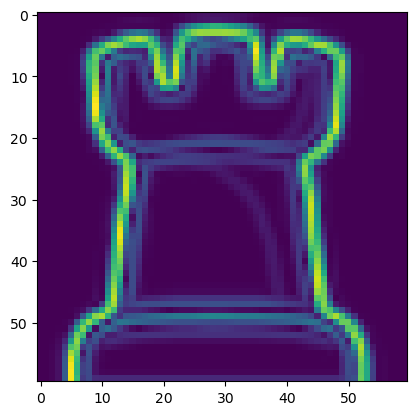

In [66]:
print(np.loadtxt("js_test_gray.txt").min(), np.loadtxt("js_test_gray.txt").max())
plt.imshow(np.loadtxt("js_test_gray.txt"))

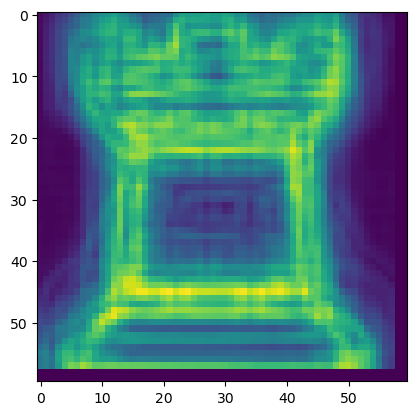

In [22]:
plt.imshow(avg_p_r)

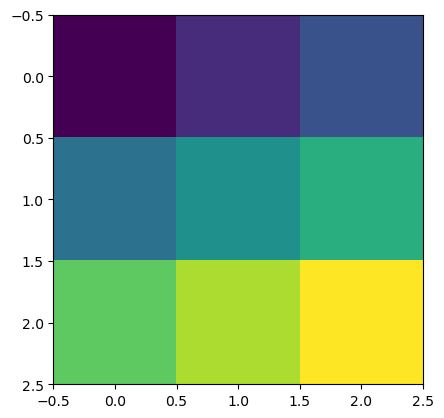

In [47]:
plt.imshow(np.loadtxt("123test.txt"))

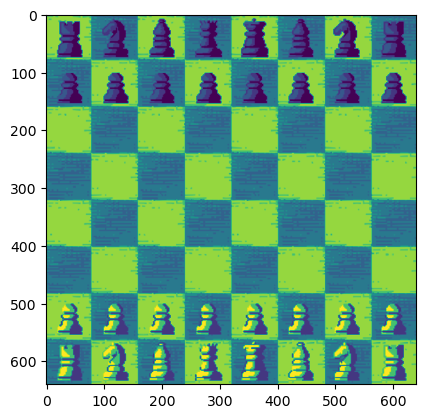

In [42]:
plt.imshow(gray_board)

In [52]:
resize_board_image("testchessboard.png")

'testchessboard.png'

In [13]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [20]:
np.max(avg_p_r), np.min(avg_p_r)

(1.0981452481854468, 0.0)

In [21]:
avg_p_r

array([[0.02903688, 0.06177311, 0.1098054 , 0.1761413 , 0.20333077,
        0.26101058, 0.32441436, 0.40330031, 0.4322541 , 0.49823562,
        0.55188164, 0.56847387, 0.62093961, 0.5496205 , 0.52138658,
        0.43733319, 0.37935818, 0.29966601, 0.3391444 , 0.35419344,
        0.40154581, 0.39520198, 0.53976778, 0.6385236 , 0.61365716,
        0.62138564, 0.6204046 , 0.64033748, 0.61378421, 0.60509352,
        0.64477268, 0.62222652, 0.54544076, 0.56056029, 0.43145354,
        0.40308069, 0.35963914, 0.41311571, 0.39660003, 0.41291229,
        0.43526998, 0.43072315, 0.49510457, 0.53179309, 0.52975087,
        0.6074295 , 0.5873675 , 0.56479519, 0.61104768, 0.44814818,
        0.336085  , 0.28556273, 0.17716094, 0.15486347, 0.13715353,
        0.10649322, 0.04533972, 0.04887369, 0.        , 0.        ],
       [0.03555532, 0.07868203, 0.12391592, 0.18971508, 0.22945172,
        0.30350664, 0.36681861, 0.44614544, 0.46007124, 0.53047578,
        0.60161308, 0.63503768, 0.68458444, 0.5

In [62]:
x_knn[292]

array([72.95380579, 62.87322134, 66.38498149, 68.02047485, 64.21246386,
       60.89838926])

In [63]:
x_knn[0]

array([22.04090103, 27.9313415 , 28.21472124, 22.78103457, 30.42024368,
       29.74229583])